<a href="https://colab.research.google.com/github/maryamzamani11/Forecast_Temperature_Timeseries/blob/main/ARIMA_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pmdarima as pm

In [4]:
from google.colab import files
import io 
data = files.upload()

Saving Temperature.csv to Temperature.csv


In [11]:
df = pd.read_csv(io.BytesIO(data['Temperature.csv']))
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,North America,US,New York,New York City,1,1,1995,44.0
1,North America,US,New York,New York City,1,2,1995,41.8
2,North America,US,New York,New York City,1,3,1995,28.1
3,North America,US,New York,New York City,1,4,1995,31.7
4,North America,US,New York,New York City,1,5,1995,21.3


In [12]:
df['Date']=pd.to_datetime(df[['Year', 'Month', 'Day']])
df.drop(['Year','Month','Day'],axis=1,inplace=True)
df=df.set_index('Date')
df.head(2)

,Region,Country,State,City,AvgTemperature
Date,,,,,
1995-01-01,North America,US,New York,New York City,44.0
1995-01-02,North America,US,New York,New York City,41.8


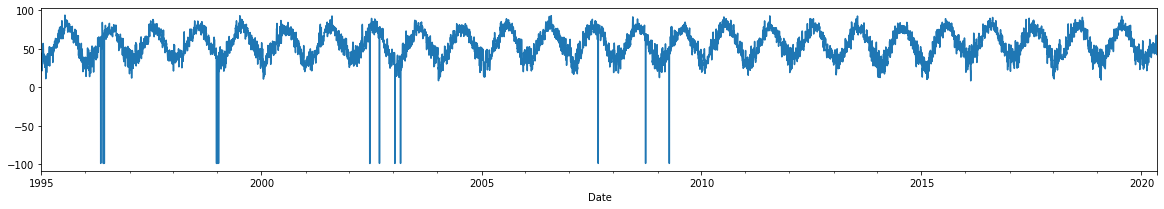

In [13]:
plt.figure(figsize=(20,3))
df['AvgTemperature'].plot()

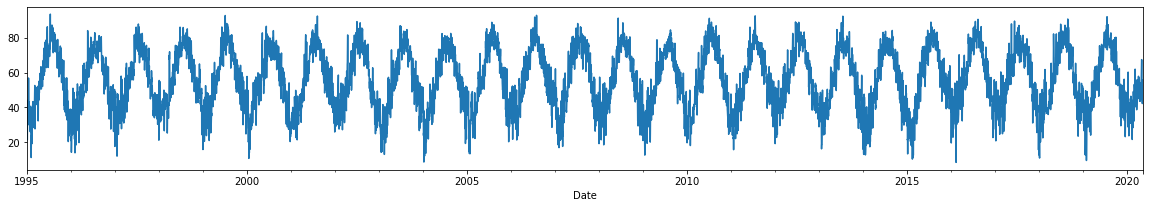

In [14]:
# Remove unusual values
df=df.assign(AvgTemperature=df.AvgTemperature.mask(df.AvgTemperature.lt(-50)).ffill())
plt.figure(figsize=(20,3))
df['AvgTemperature'].plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


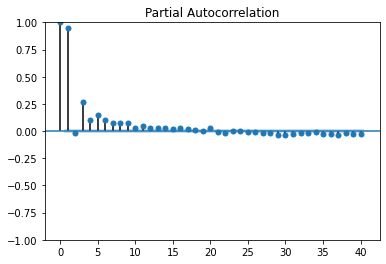

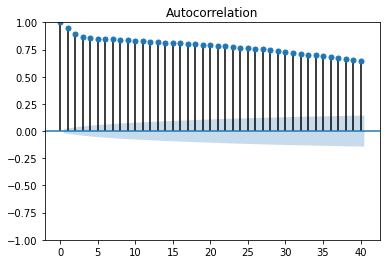

In [15]:
plot_pacf(df['AvgTemperature'])
plt.show()
plot_acf(df['AvgTemperature'])
plt.show()

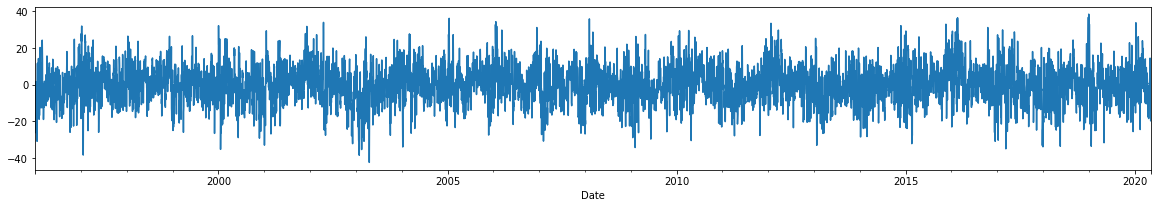

In [16]:
# Make the data stationary by removing seasonality 
df['Diff365'] = df['AvgTemperature'].diff(365) 
df.dropna(inplace=True)
df['Diff365'].plot(figsize=(20,3))

In [17]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller
adfuller(df['Diff365'])

(-16.06555690353772,
 5.578496496415827e-29,
 19,
 8880,
 {'1%': -3.4310866206444426,
  '5%': -2.8618655379853126,
  '10%': -2.566943278865859},
 59862.52756003431)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


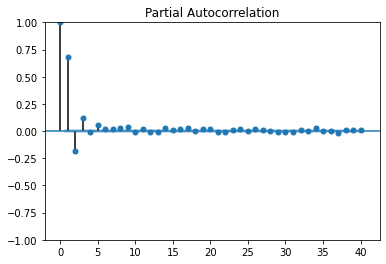

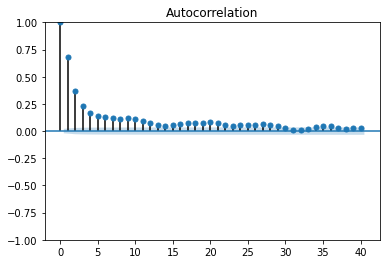

In [18]:
plot_pacf(df['Diff365'])
plt.show()
plot_acf(df['Diff365'])
plt.show()

In [19]:
# train and test split
Ntest = 10
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [20]:
# Apply auto_arima to find the bets model on the average temperature data itself.
Model_arima = pm.auto_arima(train['AvgTemperature'])

In [21]:
Model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8890
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -27293.293
Date:                Wed, 23 Nov 2022   AIC                          54598.585
Time:                        12:16:37   BIC                          54641.141
Sample:                    01-01-1996   HQIC                         54613.075
                         - 05-03-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2087      0.048      4.342      0.000       0.115       0.303
ar.L1          1.3217      0.020     66.800      0.000       1.283       1.360
ar.L2         -0.3255      0.019    -16.698      0.000      -0.364      -0.287
ma.L1         -0.4340      0.019    -23.052      0.000      -0.471      -0.397
ma.L2         -0.3477      0.011    -31.253      0.000      -0.369      -0.326
sigma2        27.1675      0.335     80.985      0.000      26.510      27.825
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               604.40
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.31
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
prediction_test, confint = Model_arima.predict(n_periods=Ntest, return_conf_int=True)

In [23]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

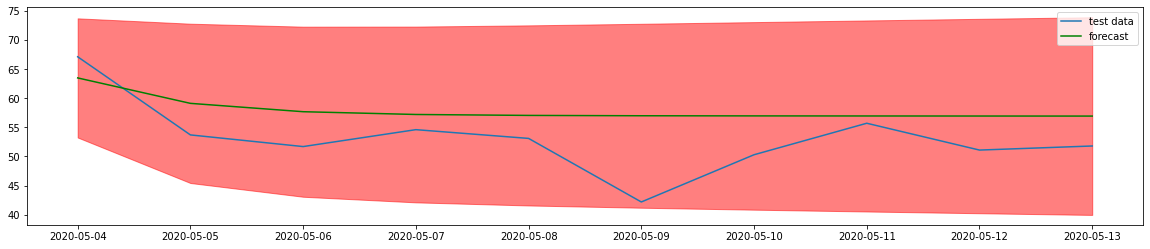

In [25]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(test.index, test['AvgTemperature'], label='test data')
ax.plot(test.index, prediction_test, color='green',label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.5)
ax.legend()


In [26]:
prediction_train = Model_arima.predict_in_sample(start=0, end=-1)


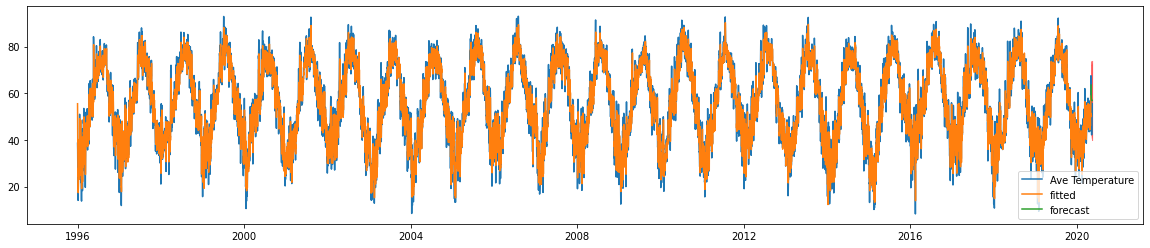

In [27]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(df.index, df['AvgTemperature'], label='Ave Temperature')
ax.plot(train.index, prediction_train, label='fitted')
ax.plot(test.index, prediction_test, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.5)
ax.legend()


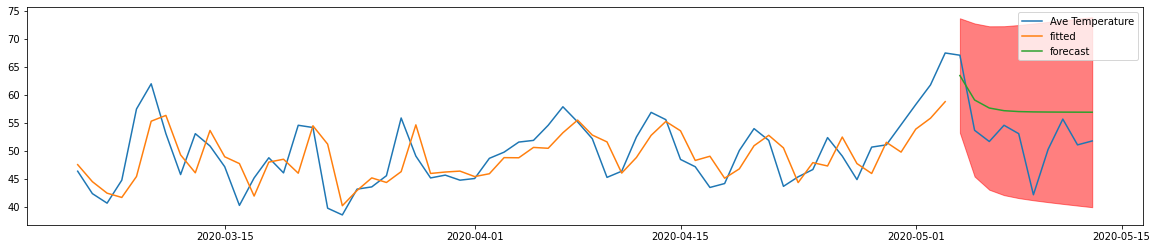

In [31]:
# Zoom in the last 70 days of the data 
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(df.index[-70:], df['AvgTemperature'][-70:], label='Ave Temperature')
ax.plot(train.index[-60:], prediction_train[-60:], label='fitted')
ax.plot(test.index, prediction_test, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.5)
ax.legend()

# **We repeat above for the stationary dataset.**

In [34]:
Model_arima_diff = pm.auto_arima(train['Diff365'])

In [35]:
Model_arima_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8890
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -30034.189
Date:                Wed, 23 Nov 2022   AIC                          60078.378
Time:                        12:35:53   BIC                          60113.841
Sample:                    01-01-1996   HQIC                         60090.452
                         - 05-03-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3898      0.022     63.978      0.000       1.347       1.432
ar.L2         -0.4104      0.018    -23.077      0.000      -0.445      -0.376
ma.L1         -0.5606      0.021    -26.357      0.000      -0.602      -0.519
ma.L2         -0.3451      0.012    -28.194      0.000      -0.369      -0.321
sigma2        50.3407      0.640     78.705      0.000      49.087      51.594
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               245.82
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
prediction_diff_test, confint_diff = Model_arima_diff.predict(n_periods=Ntest, return_conf_int=True)

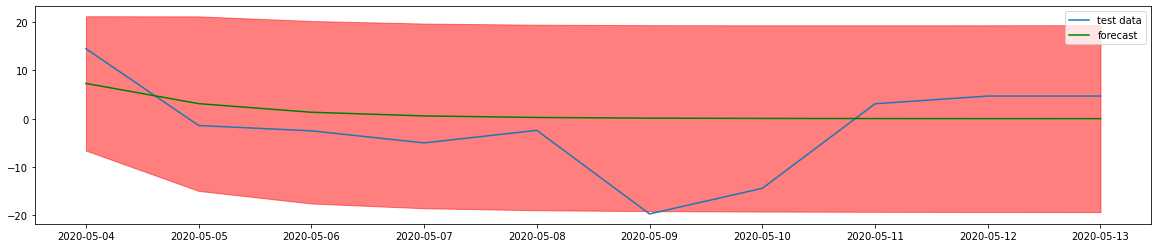

In [37]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(test.index, test['Diff365'], label='test data')
ax.plot(test.index, prediction_diff_test, color='green',label='forecast')
ax.fill_between(test.index, confint_diff[:,0], confint_diff[:,1], color='red', alpha=0.5)
ax.legend()

In [38]:
prediction_diff_train = Model_arima_diff.predict_in_sample(start=0, end=-1)


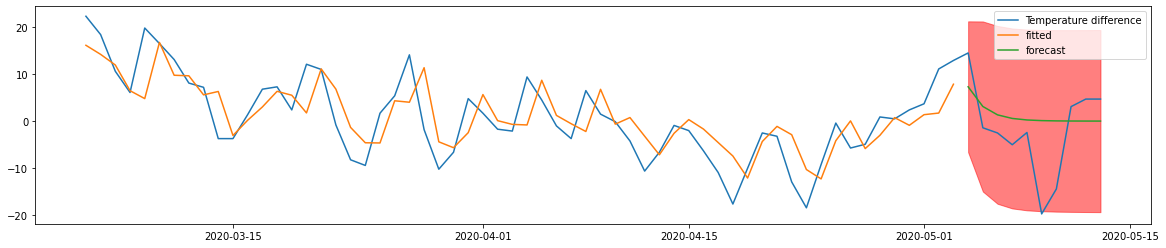

In [43]:
# Zoom in the last 70 days of the data 
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(df.index[-70:], df['Diff365'][-70:], label='Temperature difference')
ax.plot(train.index[-60:], prediction_diff_train[-60:], label='fitted')
ax.plot(test.index, prediction_diff_test, label='forecast')
ax.fill_between(test.index, confint_diff[:,0], confint_diff[:,1], color='red', alpha=0.5)
ax.legend()


In [41]:
df.loc[train_idx, 'Train pred of differencing'] = prediction_diff_train
df.loc[test_idx, 'Test pred of differencing'] = prediction_diff_test

In [51]:
df['ShiftTemperature'] = df['AvgTemperature'].shift(365)

df.loc[train_idx, 'prediction'] = df['Train pred of differencing'] + df['ShiftTemperature']
df.loc[test_idx, 'prediction'] = df['Test pred of differencing'] + df['ShiftTemperature']

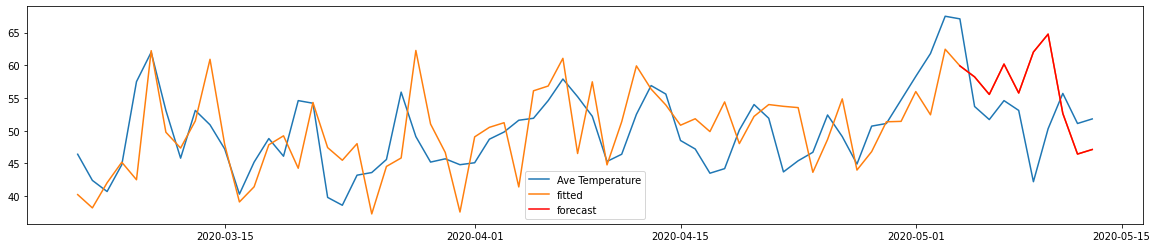

In [53]:
# Zoom in the last 70 days of the data 
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(df.index[-70:], df['AvgTemperature'][-70:], label='Ave Temperature')
ax.plot(df.index[-70:], df['prediction'][-70:], label='fitted')
ax.plot(df.index[-10:], df['prediction'][-10:], label='forecast',color='red')
#ax.fill_between(test.index, confint_diff[:,0], confint_diff[:,1], color='red', alpha=0.5)
ax.legend()


# **Above results show that ARIMA model on stationary dataset captures the fluctuations in the test dataset. But below you see the second model has higher RMSE**

In [64]:
# RMSE
def RMSE(x,y):
  return np.sqrt(np.mean((x-y)**2))


In [69]:
print('first model on data with seasonality', RMSE(test['AvgTemperature'],prediction_test))
print('second model on stationary data without seasonality', RMSE(test['AvgTemperature'],df.loc[test_idx, 'prediction']))

first model on data with seasonality 6.522350765444411
second model on stationary data without seasonality 8.835144929247395


In [70]:
from sklearn.metrics import mean_absolute_percentage_error

In [71]:
MAPE_first_model = mean_absolute_percentage_error(test['AvgTemperature'],prediction_test)
MAPE_second_model = mean_absolute_percentage_error(test['AvgTemperature'],df.loc[test_idx, 'prediction'])

In [72]:
print('MAPE first model',MAPE_first_model)
print('MAPE second model', MAPE_second_model)

MAPE first model 0.11108325957748846
MAPE second model 0.14123092284209013
